# 3D elastic VTI wave equation implementation on a staggered grid

This is a first attempt at implementing the elastic wave equations in 3D vertical transversely isotropic (VTI) media as described in [1].

The notebook implements various Finite Difference schemes to solve this PDE and recreate the results from various forward simulations.

<br> Chirayu Khimji 
<br> Independent Research Project 
<br> MSc Applied Computational Science and Engineering - Imperial College London 
<br> IRP Supervisors: Dr. Gerard Gorman, Dr. Rhodri Nelson and the Devito Project Research Group

## Introduction

To be added in proper academic syntax

## Outline
this cell needs to be completed in more detail when tasks below are completed

1. Scalar PDE Implementation for 3D elastic VTI wave propagation using temporal high-accuracy staggered-grid finite-difference scheme

2. Vectorial PDE Implementation for 3D elastic VTI wave propagation (Vectorized Approach) using temporal high-accuracy staggered-grid finite-difference scheme

3. Implementation Testing: Comparing the results of these two implementations against an pure Elastic Isotropic Implementation

4. Accuracy Testing: 

# Scalar PDE Implementation: 3D Elastic VTI wave-equations
The paper [1] expresses the elastic wave equations as a set of scalar PDEs in conventional velocity-stress format: 

$$
\begin{aligned}
\frac{\partial v_x}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xx}}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + \frac{\partial \tau_{xz}}{\partial z} \right) \\
\frac{\partial v_y}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xy}}{\partial x} + \frac{\partial \tau_{yy}}{\partial y} + \frac{\partial \tau_{yz}}{\partial z} \right) \\
\frac{\partial v_z}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xz}}{\partial x} + \frac{\partial \tau_{yz}}{\partial y} + \frac{\partial \tau_{zz}}{\partial z} \right) \\
\frac{\partial \tau_{xx}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} - 2c_{66}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{yy}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} - 2c_{66}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{zz}}{\partial t} &= c_{13}\frac{\partial v_{x}}{\partial x} + c_{13}\frac{\partial v_{y}}{\partial y} + c_{33}\frac{\partial v_{z}}{\partial z} \\
\frac{\partial \tau_{zz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial x} + c_{44}\frac{\partial v_{x}}{\partial z} \\
\frac{\partial \tau_{yz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial y} + c_{44}\frac{\partial v_{y}}{\partial z} \\
\frac{\partial \tau_{xy}}{\partial t} &= c_{66}\frac{\partial v_{y}}{\partial x} + c_{66}\frac{\partial v_{x}}{\partial y} \\
\end{aligned}
$$

Stiffness coefficients in elastic VTI media can be given by (Thomsen 1986):

$
\begin{aligned}
c_{11} &= \rho \left(1 + 2\epsilon\right)v_{p0}^{2} \\
c_{33} &= \rho v_{p0}^{2} \\
c_{44} &= \rho v_{s0}^{2} \\
c_{66} &= \rho \left(1 + 2\gamma\right)v_{s0}^{2} \\
c_{13} &= \rho v_{p0}^{2}\sqrt{f\left(f + 2\delta\right)} - \rho v_{s0}^{2} \\
f &= 1 - v_{s0}^{2}/v_{p0}^{2} \\
\end{aligned}
$




### Imports
For consistency, all required imports used by this notebook are below:

In [1]:
# Required imports:
import numpy as np

from devito import configuration, norm
from examples.seismic import plot_velocity, RickerSource, TimeAxis, Receiver, plot_image, AcquisitionGeometry, setup_geometry, seismic_args
from model_VTI import ModelElasticVTI
from elastic_VTI_solvers import *

import matplotlib.pyplot as plt

from sympy import init_printing, latex
init_printing(use_latex='mathjax')

%matplotlib inline

plt.rc('font', size=14)

# default language set to openmp i.e. Code Generated by Devito will be in openmp
#configuration['language'] = 'openmp'

# logging set to debug to capture statistics on the performance of operators
configuration['log-level'] = 'DEBUG'

# define precision type: 32bit floating point
dtype = np.float32


### Instantiate Devito grid for a three dimensional problem
For initial implementation testing, grid setup equivalent to devito/examples/seismic/tutorials/06_elastic.ipynb

In [2]:
# Define dimensions for the interior of the model 
nx, ny, nz = 201, 201, 201          # Number of grid points
dx, dy, dz = 7.5, 7.5, 7.5          # Grid spacing in m
shape = (nx, ny, nz)                # Domain shape 
spacing = (dx, dy, dz)              # Domain size is now 5 km by 5 km
origin = (0., 0., 0.)               # Origin of coordinate system, specified in m.
extent = tuple([i*(n-1) for i, n in zip(spacing, shape)])

### Multilayered Model

Run this code block if you would like to use a Multilayered Model

In [26]:
#Thomsen's anisotropy parameters
epsilon = 0.25
delta = 0.10
gamma = 0.05

# Define a physical size
nlayers = 3
npad = 50

so = 4 #spatial order
to = 1 #temporal order

# Model physical parameters:
vp = np.zeros(shape)
vs = np.zeros(shape)
rho = np.zeros(shape)

# Define a Vp profile. The velocity is in km/s
vp_top = 1.5
vp_bottom = 3.5

# Define a Vs profile. The velocity is in km/s
vs_top = 1.5
vs_bottom = 3.5

# Define a velocity profile in km/s
v_p = np.empty(shape, dtype=dtype)
v_p[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, nlayers)
for i in range(1, nlayers):
    v_p[..., i*int(shape[-1] / nlayers):] = vp_i[i]  # Bottom velocity

v_s = np.empty(shape, dtype=dtype)
v_s[:] = vs_top  # Top velocity (background)
vs_i = np.linspace(vs_top, vs_bottom, nlayers)
for i in range(1, nlayers):
    v_s[..., i*int(shape[-1] / nlayers):] = vs_i[i]  # Bottom velocity

rho[:] = 0.31*(v_p[:]*1000.)**0.25 # Gardner's relation

model = ModelElasticVTI(origin=origin, spacing = spacing, shape=shape, space_order=so, 
vp=v_p, vs=v_s, rho=rho, epsilon=epsilon, delta=delta, gamma=gamma, nbl = npad, dtype = dtype, bcs = "mask")


print("")
print("Grid Setup:")
print("Shape:       ", model.grid.shape)
print("Origin:      ", origin)
print("Grid Spacing: ", model.grid.spacing_map)
print("Extent:      ", model.grid.extent)

Operator `initdamp` generated in 0.17 s
  * lowering.Clusters: 0.08 s (47.3 %)
     * specializing.Clusters: 0.05 s (29.6 %)
  * lowering.Expressions: 0.05 s (29.6 %)
  * lowering.IET: 0.05 s (29.6 %)
Flops reduction after symbolic optimization: [102 --> 102]
Allocating memory for damp(303, 303, 303)
Operator `initdamp` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/45d77e2623ece35a7ebe4724e555e318bf6bea06.c` in 0.08 s from jit-cache
Operator `initdamp` run in 0.20 s
* section0<<301,301,301>,<50,301,301>,<50,301,301>,<301,50,301>,<301,50,301>,<301,301,50>,<301,301,50>> with OI=0.01 computed in 0.20 s [2.42 GFlops/s]
Performance[mode=advanced] arguments: {}
Allocating memory for vp(309, 309, 309)
Operator `padfunc` generated in 0.13 s
  * lowering.IET: 0.05 s (41.6 %)
     * specializing.IET: 0.03 s (25.0 %)
  * lowering.Clusters: 0.05 s (41.6 %)
  * lowering.Expressions: 0.03 s (25.0 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `p

Velocity Model Plots:


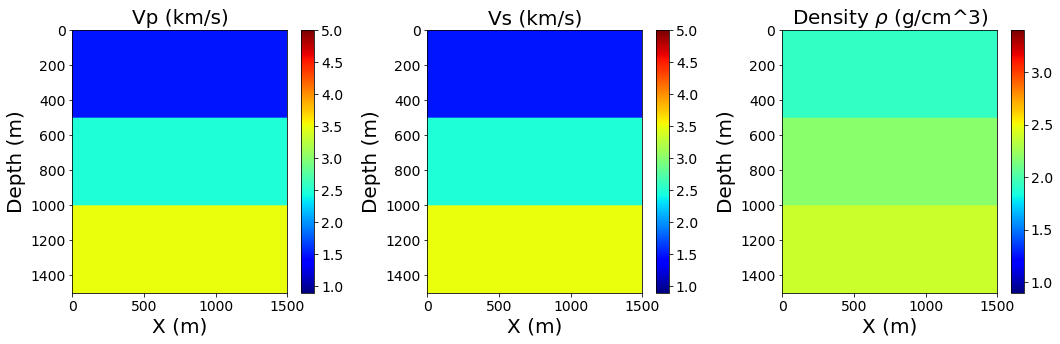

In [27]:
# Code to plot model attributes
def plot_model(model):
    print("Velocity Model Plots:")

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0], model.origin[0] + model.domain_size[0],
                                                model.origin[-1] + model.domain_size[-1], model.origin[-1]]}
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
    img1 = ax[0].imshow(np.transpose(model.vp.data[0][slices]), vmin=0.9, vmax=5, **plt_options_model)
    fig.colorbar(img1, ax=ax[0])
    ax[0].set_title(r"Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('X (m)', fontsize=20)
    ax[0].set_ylabel('Depth (m)', fontsize=20)
    ax[0].set_aspect('auto')

    img2 = ax[1].imshow(np.transpose(model.vs.data[0][slices]), vmin=0.9, vmax=5, **plt_options_model)
    fig.colorbar(img2, ax=ax[1])
    ax[1].set_title(r"Vs (km/s)", fontsize=20)
    ax[1].set_xlabel('X (m)', fontsize=20)
    ax[1].set_ylabel('Depth (m)', fontsize=20)
    ax[1].set_aspect('auto')

    img3 = ax[2].imshow(np.transpose(model.rho.data[0][slices]), vmin=0.9, vmax=3.4, **plt_options_model)
    fig.colorbar(img3, ax=ax[2])
    ax[2].set_title(r"Density $\rho$ (g/cm^3)", fontsize=20)
    ax[2].set_xlabel('X (m)', fontsize=20)
    ax[2].set_ylabel('Depth (m)', fontsize=20)
    ax[2].set_aspect('auto')

    plt.tight_layout()

## Plot Multilayered Model
plot_model(model)

### Single Layered Model  
Run the code block below instead for a single layered model

In [28]:
#Model Absorbing Boundaries
npad = 20

#Thomsen's anisotropy parameters
epsilon = 0.25
delta = 0.10
gamma = 0.05

#initial conditions
v_p = np.zeros(shape)
v_s = np.zeros(shape)
rho = np.zeros(shape)

v_p[:] = 2.0 #km/s
v_s[:] = 1.0 #km/s
rho[:] = 1.8 #kg/m**3

so = 4 #spatial order
to = 1 #temporal order

model = ModelElasticVTI(origin=origin, spacing = spacing, shape=shape, space_order=so, 
vp=v_p, vs=v_s, rho=rho, epsilon=epsilon, delta=delta, gamma=gamma, nbl = npad, dtype = dtype, bcs = "mask")

print("")
print("Grid Setup:")
print("Shape:       ", model.grid.shape)
print("Origin:      ", origin)
print("Grid Spacing: ", model.grid.spacing_map)
print("Extent:      ", model.grid.extent)

Operator `initdamp` generated in 0.17 s
  * lowering.Clusters: 0.08 s (47.5 %)
     * specializing.Clusters: 0.05 s (29.7 %)
  * lowering.Expressions: 0.05 s (29.7 %)
  * lowering.IET: 0.05 s (29.7 %)
Flops reduction after symbolic optimization: [102 --> 102]
Allocating memory for damp(243, 243, 243)
Operator `initdamp` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/5818e98a502780ac5c5da091323ca30a180fa0bd.c` in 0.06 s from jit-cache
Operator `initdamp` run in 0.07 s
* section0<<241,241,241>,<20,241,241>,<20,241,241>,<241,20,241>,<241,20,241>,<241,241,20>,<241,241,20>> with OI=0.01 computed in 0.07 s [1.81 GFlops/s]
Performance[mode=advanced] arguments: {}
Allocating memory for vp(249, 249, 249)
Operator `padfunc` generated in 0.13 s
  * lowering.IET: 0.06 s (48.7 %)
     * specializing.IET: 0.03 s (24.4 %)
  * lowering.Clusters: 0.05 s (40.6 %)
  * lowering.Expressions: 0.03 s (24.4 %)
Flops reduction after symbolic optimization: [0 --> 0]
Operator `p

Velocity Model Plots:


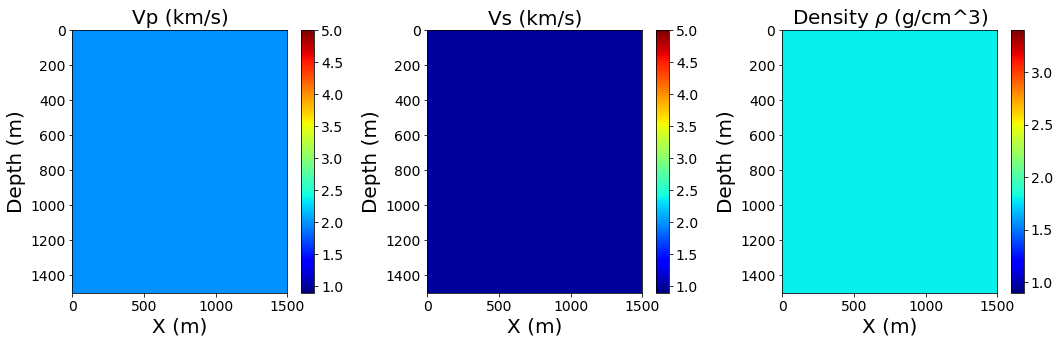

In [29]:
plot_model(model)

### Devito's Symbolic Objects are now defined on the `grid` 
The symbolic objects `Function`, `VectorTimeFunction` and `TensorTimeFunction` define the physics of Wavefields onto the grid. These objects account for both spatially varying and time dependent features of Wavefields.

In [17]:
# PDE functions assigned to model:
x, y, z = model.grid.dimensions
# dampening function assigned to model:
damp = model.damp

# Now we create the velocity and pressure fields

#Velocity
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)

#Stress
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

# Symbolic definition of the model grid spacing for a staggered grid
ts = model.grid.stepping_dim.spacing 

### Define the simulation time range

In [18]:
t0 = 0.     # Simulation time start
tn = 500. #300.  # Simulation time end (1 second = 1000 msec)

dt = model.critical_dt #time step computed from elastic VTI CFL condition

time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time range: ", time_range)

Allocating memory for n(1,)
Time range:  TimeAxis: start=0, stop=500.52, step=1.164, num=431


### Setting up the acquisition geometry: locations of explosive source and recievers

For an example simulation:
A 10 Hz center frequency Ricker wavelet source, located at (x, y, z) = (750m, 750m, 750m) and is added into $v_x$ component to generate vibration.

For Ricker wavelet, the source signature $g(t)$ is the derivative of a Gaussian pulse:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

Allocating memory for src(431, 1)
Allocating memory for src_coords(1, 3)
Allocating memory for rec_coords(301, 3)
Allocating memory for rec2_coords(301, 3)
Allocating memory for rec3_coords(301, 3)
src_coords [x,y,z]: [[750. 750. 750.]]


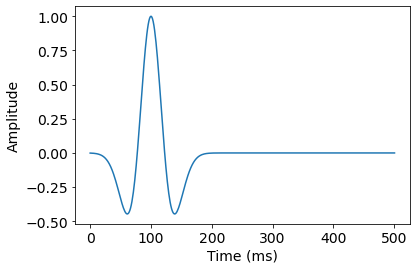

In [19]:
# Centered Source with 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=model.grid, f0=fpeak, time_range=time_range)
src.coordinates.data[:] = np.array([750., 750., 750.])

#rec = Receiver(name='rec', grid=model.grid, npoint = shape[0], time_range=time_range)
#rec.coordinates.data[:,0] = dx * (nx/2)
#rec.coordinates.data[:,1] = 6
#rec.coordinates.data[:,2] = np.linspace(0.0, dz*(nz-1), nz)


# The receiver
nrec = 301
rec = Receiver(name="rec", grid=model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec.coordinates.data[:, 1] = 0 #model.grid.extent[0]/2
rec.coordinates.data[:, -1] = 5.

rec2 = Receiver(name="rec2", grid=model.grid, npoint=nrec, time_range=time_range)
rec2.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec2.coordinates.data[:, 1] = 0 #model.grid.extent[0]/2
rec2.coordinates.data[:, -1] = 5.

rec3 = Receiver(name="rec3", grid=model.grid, npoint=nrec, time_range=time_range)
rec3.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec3.coordinates.data[:, 1] = 0 #model.grid.extent[0]/2
rec3.coordinates.data[:, -1] = 5.


print("src_coords [x,y,z]:", src.coordinates.data)
#print("rec_coords [x,y,z]:", rec.coordinates.data)

#plot time signature to view wavelet
src.show()

In [20]:
## Symbolic Parameters used from the model
irho = model.irho #irho = 1/rho

c11 = model.c11
c33 = model.c33
c44 = model.c44
c66 = model.c66
c13 = model.c13

In [21]:
#3D source injection term
src_xx = src.inject(field=tau[0, 0].forward, expr=src*ts)
src_yy = src.inject(field=tau[1, 1].forward, expr=src*ts)
src_zz = src.inject(field=tau[2, 2].forward, expr=src*ts)

# 3D interpolation expression for receivers
rec_xx = rec.interpolate(expr=v[0])
rec_yy = rec2.interpolate(expr=v[1])
rec_zz = rec3.interpolate(expr=v[2])
#rec_term = rec.interpolate(expr=tau.forward)

src_term = src_xx + src_yy + src_zz
rec_term = rec_xx + rec_yy + rec_zz
src_rec = src_term + rec_term

### Implementation with Absorbing BCs
Assemble scalar PDEs individually

In [22]:
# Define Scalar stencil for VTI operators with absorbing BCs:

# Particle Velocity for each direction
u_vx = Eq(v[0].forward, damp*v[0] + damp*ts*irho*(tau[0,0].dx + tau[1,0].dy + tau[2,0].dz) )
u_vy = Eq(v[1].forward, damp*v[1] + damp*ts*irho*(tau[0,1].dx + tau[1,1].dy + tau[1,2].dz) )
u_vz = Eq(v[2].forward, damp*v[2] + damp*ts*irho*(tau[0,2].dx + tau[2,1].dy + tau[2,2].dz) )

# Stress for each direction in VTI Media:
u_txx = Eq(tau[0,0].forward, damp*tau[0,0] + damp*ts*(c11*v[0].forward.dx + c11*v[1].forward.dy - 2*c66*v[1].forward.dy + c13*v[2].forward.dz) )
u_tyy = Eq(tau[1,1].forward, damp*tau[1,1] + damp*ts*(c11*v[0].forward.dx - 2*c66*v[0].forward.dx + c11*v[1].forward.dy + c13*v[2].forward.dz) )
u_tzz = Eq(tau[2,2].forward, damp*tau[2,2] + damp*ts*(c13*v[0].forward.dx + c13*v[1].forward.dy + c33*v[2].forward.dz) )

u_txz = Eq(tau[0,2].forward, damp*tau[0,2] + damp*ts*(c44*v[2].forward.dx + c44*v[0].forward.dz) )
u_tyz = Eq(tau[1,2].forward, damp*tau[1,2] + damp*ts*(c44*v[2].forward.dy + c44*v[1].forward.dz) )
u_txy = Eq(tau[0,1].forward, damp*tau[0,1] + damp*ts*(c66*v[1].forward.dx + c66*v[0].forward.dy) )

stencil = [u_vx, u_vy, u_vz, u_txx, u_tyy, u_tzz, u_txz, u_tyz, u_txy]

pde = stencil + src_rec

### Forward Simulation 

Define forward propogator using the Devito `Operator`. `Operator` will generate optimized C code which is JIT-compiled and ready to run.

In [23]:
#Assemble the operator matrix with the correct model spacing

op_fwd = Operator(pde, subs=model.spacing_map)

Operator `Kernel` generated in 3.22 s
  * lowering.Expressions: 1.37 s (42.7 %)
  * lowering.Clusters: 0.86 s (26.8 %)
  * lowering.IET: 0.82 s (25.6 %)
Flops reduction after symbolic optimization: [306 --> 166]


In [14]:
#Uncomment to Print generated c++ code
#print(op_fwd_prop)

This demonstration shows that `Operator` makes it very trivial to create a fully functional computational kernal for elastic wave propogation in VTI media in just a few lines of python.   
Now we run `op_fwd` for forward simulation.

In [15]:
#NBVAL_IGNORE_OUTPUT

#Forward Simulation with the critical computed timestep 
op_fwd(dt=dt)

Allocating memory for rec(431, 301)
Allocating memory for rec2(431, 301)
Allocating memory for rec3(431, 301)
Allocating memory for t_xx(2, 249, 249, 249)
Allocating memory for t_xy(2, 249, 249, 249)
Allocating memory for t_xz(2, 249, 249, 249)
Allocating memory for t_yy(2, 249, 249, 249)
Allocating memory for t_yz(2, 249, 249, 249)
Allocating memory for t_zz(2, 249, 249, 249)
Allocating memory for v_x(2, 249, 249, 249)
Allocating memory for v_y(2, 249, 249, 249)
Allocating memory for v_z(2, 249, 249, 249)
Operator `Kernel` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/aae26e86d5e049c86fb01fd2de8626c8c29313cf.c` in 0.41 s from jit-cache


In [ ]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

In [ ]:
assert np.isclose(norm(v[0]), 0.037024777, atol=1e-4, rtol=0)

In [ ]:
def plot_v(model, v):
    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
    scale = .5*1e-7

    plt_options_model = {'extent': [model.origin[0] , model.origin[0] + model.domain_size[0],
                                    model.origin[-1] + model.domain_size[-1], model.origin[-1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
    ax[0].imshow(np.transpose(v[0].data[0][:,-1][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[0].imshow(np.transpose(model.vp.data[0][slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[0].set_aspect('auto')
    ax[0].set_xlabel('X (m)', fontsize=20)
    ax[0].set_ylabel('Depth (m)', fontsize=20)
    ax[0].set_title(r"$v_{x}$", fontsize=20)

    ax[1].imshow(np.transpose(v[1].data[0][:,-1][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[1].imshow(np.transpose(model.vp.data[0][slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[1].set_aspect('auto')
    ax[1].set_xlabel('X (m)', fontsize=20)
    ax[1].set_title(r"$v_{y}$", fontsize=20)

    ax[2].imshow(np.transpose(v[-1].data[0][:,-1][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[2].imshow(np.transpose(model.vp.data[0][slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[2].set_aspect('auto')
    ax[2].set_xlabel('X (m)', fontsize=20)
    ax[2].set_title(r"$v_{z}$", fontsize=20)

def plot_tau(model, tau):
    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]
    scale = .5*1e-7

    plt_options_model = {'extent': [model.origin[0] , model.origin[0] + model.domain_size[0],
                                    model.origin[-1] + model.domain_size[-1], model.origin[-1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 7))
    ax[0].imshow(np.transpose(tau[0,0].data[0][:,-1][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[0].imshow(np.transpose(model.vp.data[0][slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[0].set_aspect('auto')
    ax[0].set_xlabel('X (m)', fontsize=20)
    ax[0].set_ylabel('Depth (m)', fontsize=20)
    ax[0].set_title(r"$\tau_{xx}$", fontsize=20)

    ax[1].imshow(np.transpose(tau[1,1].data[0][:,-1][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[1].imshow(np.transpose(model.vp.data[0][slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[1].set_aspect('auto')
    ax[1].set_xlabel('X (m)', fontsize=20)
    ax[1].set_title(r"$\tau_{yy}$", fontsize=20)

    ax[2].imshow(np.transpose(tau[2,2].data[0][:,-1][slices]), vmin=-scale, vmax=scale, cmap="RdGy", **plt_options_model)
    ax[2].imshow(np.transpose(model.vp.data[0][slices]), vmin=1.5, vmax=3.5, cmap="jet", alpha=.5, **plt_options_model)
    ax[2].set_aspect('auto')
    ax[2].set_xlabel('X (m)', fontsize=20)
    ax[2].set_title(r"$\tau_{zz}$", fontsize=20)

plot_v(model, v)
plot_tau(model, tau)

### Reciever Shot Record to go here -- not working


In [ ]:
# Data on a standard 2ms tim axis
rec_plot = rec.resample(num=1001)
rec2_plot = rec2.resample(num=1001)
rec3_plot = rec3.resample(num=1001)

In [ ]:
scale_for_plot = np.diag(np.linspace(1.0, 2.5, 1001)**2.0)

In [ ]:
rec_plot.coordinates.data.shape

In [ ]:
def plot_receiver(rec): ## This function is not giving desired results
    rec_plot = rec.resample(num=1001)
    rec2_plot = rec2.resample(num=1001)
    rec3_plot = rec3.resample(num=1001)

    extent = [rec_plot.coordinates.data[0, 0], rec_plot.coordinates.data[-1, 0], 1e-3*tn, t0]
    aspect = rec_plot.coordinates.data[-1, 0]/(1e-3*tn)/.5

    plt.figure(figsize=(10, 10))
    #plt.imshow(rec_plot.data, vmin=-.001, vmax=.1, cmap="seismic",
    plt.imshow(rec_plot.data, cmap="seismic", 
           interpolation='lanczos', extent=extent, aspect=aspect)
    plt.ylabel("Time (s)", fontsize=20)
    plt.xlabel("Receiver position (m)", fontsize=20)

print(np.unique(rec.data), np.unique(rec2.data), np.unique(rec3.data)) ## Why are these numbers so small ?
plot_receiver(rec)

### Function to reset Pressure and Velocity fields between operator runs


In [ ]:
#Reset Fields
def reset_fields(v, tau):
    v[0].data[:] = 0
    v[1].data[:] = 0
    v[2].data[:] = 0

    tau[0,0].data[:] = 0
    tau[0,1].data[:] = 0
    tau[0,2].data[:] = 0

    tau[1,0].data[:] = 0
    tau[1,1].data[:] = 0
    tau[1,2].data[:] = 0

    tau[2,0].data[:] = 0
    tau[2,1].data[:] = 0
    tau[2,2].data[:] = 0
    return v, tau 

### Testing Scalar Implementation: Compute Norm of Elastic Wave Equation in Vectorial form for Isotropic Media

We use the material from the examples/seismic/acoustic/accuracy.ipynb notebook.

In [ ]:
#Thomsen's anisotropy parameters
epsilon = 0
delta = 0
gamma = 0

#Initial Conditions
v_p = 2.0 #km/s
v_s = 1.0 #km/s
rho = 1.8 #kg/m**3

model = ModelElasticVTI(origin=origin, spacing = spacing, shape=shape, space_order=so, 
vp=v_p, vs=v_s, rho=rho, epsilon=epsilon, delta=delta, gamma=gamma, nbl = npad, dtype = dtype, bcs = "mask")

# PDE functions assigned to model:
x, y, z = model.grid.dimensions

#Velocity
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)

#Stress
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

# Symbolic definition of the model grid spacing for a staggered grid
ts = model.grid.stepping_dim.spacing 

t0 = 0.     # Simulation time start
tn = 300.  # Simulation time end (1 second = 1000 msec)

dt = model.critical_dt #time step computed from elastic VTI CFL condition

time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Centered Source with 10 Hz center frequency
fpeak = 0.010
src = RickerSource(name='src', grid=model.grid, f0=fpeak, time_range=time_range)
src.coordinates.data[:] = np.array([750., 750., 750.])

#3D source injection term
src_xx = src.inject(field=tau[0, 0].forward, expr=src*ts)
src_yy = src.inject(field=tau[1, 1].forward, expr=src*ts)
src_zz = src.inject(field=tau[2, 2].forward, expr=src*ts)

src_term = src_xx + src_yy + src_zz


In [ ]:
def vectorial_elastic(model, v, tau):
    v, tau = reset_fields(v, tau)

    # Thorbecke's parameter notation
    irho = model.irho #irho = 1/rho
    rho = model.rho
    cp2 = model.vp*model.vp
    cs2 = model.vs*model.vs

    mu = cs2*rho
    l = (cp2*rho - 2*mu)

    # fdelmodc reference implementation
    u_v = Eq(v.forward, v + ts*irho*div(tau))
    u_t = Eq(tau.forward, tau + ts * l * diag(div(v.forward)) + ts * mu * (grad(v.forward) + grad(v.forward).T))
    stencil = [u_v, u_t]

    op = Operator(stencil + src_term,  subs=model.spacing_map)
    
    #Forward Simulation
    op(dt = dt)
    return v, tau

In [ ]:
#NBVAL_IGNORE_OUTPUT

v, tau = vectorial_elastic(model, v, tau)

In [ ]:
norm_elastic = norm(v[0])
print("Normalized Velocity:", norm_elastic)

### Testing Scalar Implementation: Reduce $C_{VTI}$ to $C_{ISO}$ 

In order to test that the Scale PDE Implementation is correct, the stress tensor for VTI media can be made isotropic and should retrieve Elastic wave equations for Isotropic media. This is done by setting the Thomsen's anisotropy parameters to zero. The results generated from the converted VTI stress tensor should reproduce equivalent results as a purely Isotropic elastic problem. The elastic test case should have an identical problem setup as the elastic VTI case i.e. equivalent grid setup, model, sources etc. This test will be used to verify that the Scalar PDE Implementation of 3D Elastic VTI wave-equations is correct.


Elastic Coefficient Matrix for VTI Media [2]:

$C_{VTI} = \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} & 0 & 0 & 0 \\ c_{11} - 2c_{66} & c_{11} & c_{13} & 0 & 0 & 0 \\ c_{13} & c_{13} & c_{33} & 0 & 0 & 0 \\ 0 & 0 & 0 & c_{44} & 0 & 0 \\ 0 & 0 & 0 & 0 & c_{44} & 0 \\ 0 & 0 & 0 & 0 & 0 & c_{66} \end{bmatrix} \\ $
Where the compenents are stiffness coefficients as explained previously. 

For Isotropic media, Elastic Coefficient Matrix reduces to [3]:

$ C_{ISO} = \begin{bmatrix} \lambda + 2\mu & \lambda & \lambda & 0 & 0 & 0 \\ \lambda & \lambda + 2\mu & \lambda & 0 & 0 & 0 \\ \lambda & \lambda & \lambda + 2\mu & 0 & 0 & 0 \\ 0 & 0 & 0 & \mu & 0 & 0 \\ 0 & 0 & 0 & 0 & \mu & 0 \\ 0 & 0 & 0 & 0 & 0 & \mu \end{bmatrix} \\ $

where $\lambda$ and $\mu$ are Lamé parameters.


### Make the stress tensor for VTI media isotropic:

This can either be done by setting $\ep

By comparing both the matrices above, it is convenient to express the stiffness coefficients for VTI media in terms of generalized Lamé parameters:

$
\begin{aligned}
c_{11} &= \lambda + 2\mu \\
c_{33} &= \lambda + 2\mu \\
c_{44} &= \mu \\
c_{66} &= \mu \\
c_{13} &= \lambda \\
c_{11} - 2c_{66} &= \lambda \\ 
\end{aligned}
$


Hence:

$
\begin{aligned}
c_{11} &= c_{33} \\
c_{44} &= c_{66} \\
c_{13} &= c_{11} - 2c_{66} \\
\end{aligned}
$

This should cancel out all the anisotropy parameters and therefore make the Elastic VTI stress tensor isotropic


In [ ]:
# Setup VTI Stress tensor for Isotropic media
c11 = c33
c44 = c66
c13 = c11 - 2*c66

### Implementation without absorbing BCs

In [ ]:
def elastic_VTI_stencil_testing(model, v, tau):
    v, tau = reset_fields(v, tau)

    ## Symbolic Parameters used from the model
    irho = model.irho #irho = 1/rho
    c11 = model.c11
    c33 = model.c33
    c44 = model.c44
    c66 = model.c66
    c13 = model.c13
    
    # Particle Velocity for each direction
    u_vx = Eq(v[0].forward, v[0] + ts*irho*(tau[0,0].dx + tau[1,0].dy + tau[2,0].dz) )
    u_vy = Eq(v[1].forward, v[1] + ts*irho*(tau[0,1].dx + tau[1,1].dy + tau[1,2].dz) )
    u_vz = Eq(v[2].forward, v[2] + ts*irho*(tau[0,2].dx + tau[2,1].dy + tau[2,2].dz) )

    # Stress for each direction in VTI Media:
    u_txx = Eq(tau[0,0].forward, tau[0,0] + ts*(c11*v[0].forward.dx + c11*v[1].forward.dy - 2*c66*v[1].forward.dy + c13*v[2].forward.dz) )
    u_tyy = Eq(tau[1,1].forward, tau[1,1] + ts*(c11*v[0].forward.dx - 2*c66*v[0].forward.dx + c11*v[1].forward.dy + c13*v[2].forward.dz) )
    u_tzz = Eq(tau[2,2].forward, tau[2,2] + ts*(c13*v[0].forward.dx + c13*v[1].forward.dy + c33*v[2].forward.dz) )

    u_txz = Eq(tau[0,2].forward, tau[0,2] + ts*(c44*v[2].forward.dx + c44*v[0].forward.dz) )
    u_tyz = Eq(tau[1,2].forward, tau[1,2] + ts*(c44*v[2].forward.dy + c44*v[1].forward.dz) )
    u_txy = Eq(tau[0,1].forward, tau[0,1] + ts*(c66*v[1].forward.dx + c66*v[0].forward.dy) )

    stencil = [u_vx, u_vy, u_vz, u_txx, u_tyy, u_tzz, u_txz, u_tyz, u_txy]

    pde = stencil + src_term

    #Assemble the operator 
    op = Operator(pde, subs=model.spacing_map)
    #Forward Simulation
    op(dt=dt)

    return v, tau

In [ ]:
v, tau = elastic_VTI_stencil_testing(model, v, tau)

In [ ]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

In [ ]:
assert np.isclose(norm(v[0]), norm_elastic, atol=1e-6, rtol=0)

# Verification

Compute the error between numerical and reference solutions for increasing spatial discretization order and grid spacing. Additionally compare the time to solution with the error for these src_coords. from accuracy.ipynb

In [2]:
# Model with fixed time step value
class ModelBench(ModelElasticVTI):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1

In [3]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)


In [4]:
# Number of time steps
nt = 2001
# Time axis defined
dt = 0.1
t0 = 0.
tn = dt * (nt-1)
time = np.linspace(t0, tn, nt)
# Source peak frequency in KHz
fpeak = 0.09
f0 = fpeak

print("Time Start: ", t0 )
print("Time End: ", tn )
print("Time Step: ", dt )
print("Number of Time Steps: ", nt )
print("Source Peak Frequency: ", f0 )


Time Start:  0.0
Time End:  200.0
Time Step:  0.1
Number of Time Steps:  2001
Source Peak Frequency:  0.09


In [5]:
# Increasing grid spacing and Domain size
sizes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nsizes = len(sizes)

In [6]:
# Fine grid model
c0 = 1.5
rho= 1.8 #kg/m**3

#Thomsen's anisotropy parameters
epsilon = 0.25
delta = 0.10
gamma = 0.05


model = ModelBench(vp=c0, vs=c0, rho=rho, epsilon=epsilon, delta=delta, gamma=gamma, origin=(0., 0., 0.), spacing=(.5, .5, .5),                     bcs="damp", shape=(201, 201, 201), space_order=20, nbl=40, dtype=np.float32)

Operator `initdamp` generated in 0.17 s
  * lowering.Clusters: 0.07 s (42.4 %)
     * specializing.Clusters: 0.05 s (30.3 %)
  * lowering.Expressions: 0.05 s (30.3 %)
  * lowering.IET: 0.05 s (30.3 %)
Flops reduction after symbolic optimization: [102 --> 102]
Allocating memory for damp(283, 283, 283)
Operator `initdamp` fetched `/var/folders/kb/bc2lwpvd4kj2k3qjll_cmwp80000gn/T/devito-jitcache-uid501/624b4455001f27d77e8620a18c0893867bdf4357.c` in 0.08 s from jit-cache
Operator `initdamp` run in 0.15 s
* section0<<40,281,281>,<40,281,281>,<281,40,281>,<281,40,281>,<281,281,40>,<281,281,40>> with OI=0.01 computed in 0.15 s [2.28 GFlops/s]
Performance[mode=advanced] arguments: {}


In [7]:
# Source and receiver geometries
src_coordinates = np.empty((1, 3))
src_coordinates[0, :] = 100.

# Single receiver offset 100 m from source
rec_coordinates = np.empty((1, 3))
rec_coordinates[:, :] = 150.

print("The computational Grid has (%s, %s, %s) grid points "
       "and a physical extent of (%sm, %sm, %sm)" % (*model.grid.shape, *model.grid.extent))
print("Source is at the center with coordinates", src_coordinates)
print("Receiver (single receiver) is located at", rec_coordinates)
    

# Note: gets time sampling from model.critical_dt
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                                   t0=t0, tn=tn, src_type='Ricker', f0=f0, t0w=1.5/f0)

src_coordinates.shape
                

The computational Grid has (281, 281, 281) grid points and a physical extent of (140.0m, 140.0m, 140.0m)
Source is at the center with coordinates [[100. 100. 100.]]
Receiver (single receiver) is located at [[150. 150. 150.]]


(1, 3)

In [9]:
solver = ElasticVTIWaveSolver(model, geometry, space_order=4)
ref_rec, ref_u, _ = solver.forward()

Allocating memory for src_coords(1, 3)
Allocating memory for src(2001, 1)
Allocating memory for rec_coords(1, 3)
Trying to allocate more memory for symbol v_x than available on physical device, this will start swapping
Trying to allocate more memory for symbol v_y than available on physical device, this will start swapping
Trying to allocate more memory for symbol v_z than available on physical device, this will start swapping
Trying to allocate more memory for symbol tau_xx than available on physical device, this will start swapping
Trying to allocate more memory for symbol tau_xy than available on physical device, this will start swapping
Trying to allocate more memory for symbol tau_xz than available on physical device, this will start swapping
Trying to allocate more memory for symbol tau_yy than available on physical device, this will start swapping
Trying to allocate more memory for symbol tau_yz than available on physical device, this will start swapping
Trying to allocate more 

In [ ]:
# Source and receiver coordinates
sx, sz = src_coordinates[0, :]
rx, rz = rec_coordinates[0, :]

### Convergence in time

In [ ]:
#NBVAL_IGNORE_OUTPUT
dt = [0.1000, 0.0800, 0.0750, 0.0625, 0.0500]
nnt = (np.divide(150.0, dt) + 1).astype(int)

for i in range(1, 5):
    # Time axis
    t0 = 0.0
    tn = 150.0
    time = np.linspace(t0, tn, nnt[i])

    # Source geometry
    src_coordinates = np.empty((1, 3))
    src_coordinates[0, :] = 100.

    # Single receiver offset 100 m from source
    rec_coordinates = np.empty((1, 3))
    rec_coordinates[:, :] = 150.

    geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, 
                                   t0=t0, tn=tn, src_type='Ricker', f0=f0, t0w=1.5/f0)

    # Note: incorrect data size will be generated here due to AcquisitionGeometry bug ... 
    # temporarily fixed below by resizing the output from the solver
    geometry.resample(dt[i])
    print("geometry.time_axes; ", geometry.time_axis)
    
    solver = ElasticVTIWaveSolver(model, geometry, time_order=1, space_order=8)
    ref_rec1, ref_u1, _ = solver.forward(dt=dt[i])
    ref_rec1_data = ref_rec1.data[0:nnt[i],:]

    time1 = np.linspace(0.0, 3000., 20*(nnt[i]-1) + 1)
    U_t1 = analytical(20*(nnt[i]-1) + 1, model, time1, dt=time1[1] - time1[0])
    U_t1 = U_t1[0:nnt[i]]

    error_time[i] = np.linalg.norm(U_t1[:-1] - ref_rec1_data[:-1, 0], 2) / np.sqrt(nnt[i]-1)

    ratio_d = dt[i-1]/dt[i] if i > 0 else 1.0
    ratio_e = error_time[i-1]/error_time[i] if i > 0 else 1.0
    print("error for dt=%.4f is %12.6e -- ratio dt^2,ratio err; %12.6f %12.6f \n" % 
          (dt[i], error_time[i], ratio_d**2, ratio_e))
    errors_plot.append((geometry.time_axis.time_values, U_t1[:-1] - ref_rec1_data[:-1, 0]))

# References

[1] Xu, S. and Liu, Y., 2019. Modeling 3D elastic VTI wave propagation using an optimal k-space operator-based temporal high-accuracy staggered-grid finite-difference scheme. Journal of Applied Geophysics, 170, p.103847.

[2] Wang, Y., Mu, P., Duan, Y. and Wang, T., 2018. Numerical Simulation of Elastic Wave Equation and Analysis of Wave Field Characteristics in 2-D VTI Medium. Open Journal of Yangtze Oil and Gas, 3(03), p.153.

[3] Bloot, R., Schleicher, J. and Santos, L.T., 2013. On the elastic wave equation in weakly anisotropic VTI media. Geophysical Journal International, 192(3), pp.1144-1155.